In [13]:
!pip install efficientnet_pytorch

In [14]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
import os
import pandas as pd

data_dir = "/kaggle/input/plant-doc-dataset/PlantDoc-Dataset"
train_dir = os.path.join(data_dir, "train")
classes = os.listdir(train_dir)
print(classes)

# Tạo danh sách đường dẫn và nhãn
data = []
for label in classes:
    class_dir = os.path.join(train_dir, label)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            # Bạn có thể lọc theo phần mở rộng ảnh nếu cần
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                data.append({'filename': os.path.join('train', label, fname), 'label': label})

# Tạo DataFrame
df = pd.DataFrame(data)
print(df.head())

['Corn leaf blight', 'Tomato leaf', 'Tomato leaf mosaic virus', 'Squash Powdery mildew leaf', 'Potato leaf late blight', 'Soyabean leaf', 'Peach leaf', 'Tomato leaf late blight', 'Apple leaf', 'Tomato mold leaf', 'Corn Gray leaf spot', 'Tomato leaf yellow virus', 'Strawberry leaf', 'Cherry leaf', 'Apple rust leaf', 'Potato leaf early blight', 'grape leaf black rot', 'Apple Scab Leaf', 'Tomato Septoria leaf spot', 'Tomato leaf bacterial spot', 'Blueberry leaf', 'Bell_pepper leaf spot', 'Corn rust leaf', 'Bell_pepper leaf', 'grape leaf', 'Tomato Early blight leaf', 'Raspberry leaf']
                                            filename             label
0   train/Corn leaf blight/Corn leaf blight (62).jpg  Corn leaf blight
1   train/Corn leaf blight/Corn leaf blight (22).jpg  Corn leaf blight
2  train/Corn leaf blight/Corn leaf blight (158).jpg  Corn leaf blight
3   train/Corn leaf blight/Corn leaf blight (99).jpg  Corn leaf blight
4  train/Corn leaf blight/Corn leaf blight (134).jpg  Cor

In [17]:
label_to_idx = {label:idx for idx, label in enumerate(classes)}
df['label_idx'] = df['label'].map(label_to_idx)

if df['label_idx'].isnull().any():
    missing_labels = df[df['label_idx'].isnull()]['label'].unique()
    print(f"Lỗi ánh xạ nhãn. Các nhãn sau không khớp: {missing_labels}")

In [18]:
df

,filename,label,label_idx
0,train/Corn leaf blight/Corn leaf blight (62).jpg,Corn leaf blight,0
1,train/Corn leaf blight/Corn leaf blight (22).jpg,Corn leaf blight,0
2,train/Corn leaf blight/Corn leaf blight (158).jpg,Corn leaf blight,0
3,train/Corn leaf blight/Corn leaf blight (99).jpg,Corn leaf blight,0
4,train/Corn leaf blight/Corn leaf blight (134).jpg,Corn leaf blight,0
...,...,...,...
2311,train/Raspberry leaf/Raspberry leaf (64).jpg,Raspberry leaf,26
2312,train/Raspberry leaf/Raspberry leaf (33).jpg,Raspberry leaf,26
2313,train/Raspberry leaf/Raspberry leaf (6).jpg,Raspberry leaf,26
2314,train/Raspberry leaf/Raspberry leaf (75).jpg,Raspberry leaf,26


In [19]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
print(len(train_df), len(val_df))

1852 464


In [20]:
class PlantDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image']
        label = self.df.loc[idx, 'label_idx']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [21]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(degrees=0, shear=10, scale=(0.85,1.15)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [22]:
# Chỉ đọc dữ liệu từ thư mục train
train_data = []
train_dir = os.path.join(data_dir, 'train')
for label in os.listdir(train_dir):
    label_dir = os.path.join(train_dir, label)
    for img_name in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_name)
        if os.path.isfile(img_path):
            train_data.append([img_path, label])
df = pd.DataFrame(train_data, columns=['image', 'label'])

# Ánh xạ label sang index
label_to_idx = {label:idx for idx, label in enumerate(classes)}
df['label_idx'] = df['label'].map(label_to_idx)

# Chia tập train/validation từ df
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Tạo test_df từ thư mục test (để dùng ở cuối)
test_data = []
test_dir = os.path.join(data_dir, 'test')
for label in os.listdir(test_dir):
    label_dir = os.path.join(test_dir, label)
    for img_name in os.listdir(label_dir):
        img_path = os.path.join(label_dir, img_name)
        if os.path.isfile(img_path):
            test_data.append([img_path, label])
test_df = pd.DataFrame(test_data, columns=['image', 'label'])
test_df['label_idx'] = test_df['label'].map(label_to_idx)

# Tạo Dataloader cho test set
batch_size = 128

train_dataset = PlantDataset(train_df, transform=train_transform)
val_dataset = PlantDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

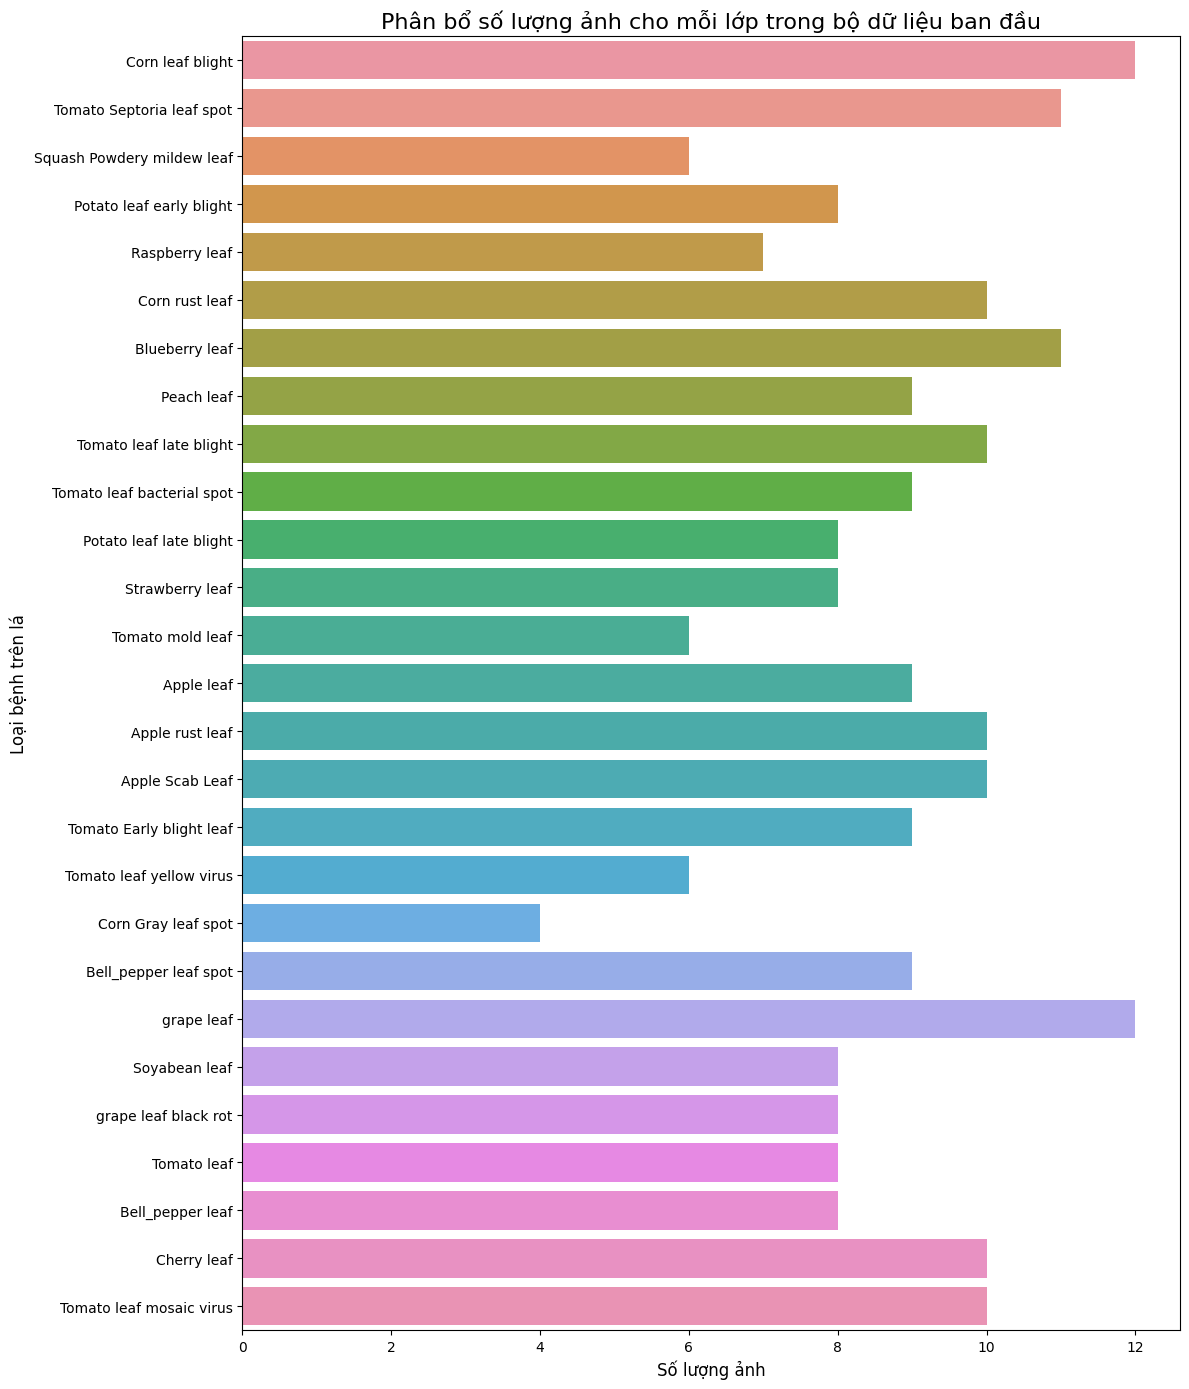

Số lượng ảnh chi tiết cho mỗi lớp:
label
Corn leaf blight              180
Tomato Septoria leaf spot     137
Squash Powdery mildew leaf    123
Potato leaf early blight      109
Raspberry leaf                109
Corn rust leaf                106
Blueberry leaf                105
Peach leaf                    103
Tomato leaf late blight       101
Tomato leaf bacterial spot     98
Potato leaf late blight        97
Strawberry leaf                88
Tomato mold leaf               85
Apple leaf                     82
Apple rust leaf                79
Apple Scab Leaf                77
Tomato Early blight leaf       74
Tomato leaf yellow virus       69
Corn Gray leaf spot            64
Bell_pepper leaf spot          62
grape leaf                     57
Soyabean leaf                  57
grape leaf black rot           56
Tomato leaf                    54
Bell_pepper leaf               53
Cherry leaf                    47
Tomato leaf mosaic virus       44
Name: count, dtype: int64


In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Đảm bảo DataFrame 'df' đã được tạo từ các ô code trước
# df chứa dữ liệu của toàn bộ tập train ban đầu

# Đặt kích thước cho biểu đồ để dễ nhìn hơn do có nhiều lớp
plt.figure(figsize=(12, 14))

# Vẽ biểu đồ đếm số lượng cho mỗi lớp
# Sử dụng y='label' để tạo biểu đồ cột ngang, giúp đọc tên các lớp dễ dàng hơn
# order=df['label'].value_counts().index sắp xếp các lớp từ có số lượng nhiều nhất đến ít nhất
sns.countplot(y='label', data=test_df, order=df['label'].value_counts().index)

plt.title('Phân bổ số lượng ảnh cho mỗi lớp trong bộ dữ liệu ban đầu', fontsize=16)
plt.xlabel('Số lượng ảnh', fontsize=12)
plt.ylabel('Loại bệnh trên lá', fontsize=12)
plt.tight_layout() # Tự động điều chỉnh các tham số để biểu đồ vừa vặn
plt.show()

# Để xem con số chính xác, bạn có thể in ra kết quả của value_counts()
print("Số lượng ảnh chi tiết cho mỗi lớp:")
print(df['label'].value_counts())

In [36]:
import pandas as pd

def tinh_tong_so_luong_anh(df_train, df_val, df_test):
    """
    Hàm này nhận vào các DataFrame của tập train, validation và test,
    sau đó in ra số lượng ảnh trong mỗi tập và tổng cộng.

    Args:
        df_train (pd.DataFrame): DataFrame chứa dữ liệu huấn luyện.
        df_val (pd.DataFrame): DataFrame chứa dữ liệu kiểm định.
        df_test (pd.DataFrame): DataFrame chứa dữ liệu kiểm tra.
    """
    so_luong_train = len(df_train)
    so_luong_val = len(df_val)
    so_luong_test = len(df_test)

    tong_huan_luyen = so_luong_train + so_luong_val
    tong_cong = tong_huan_luyen + so_luong_test

    print("--- THỐNG KÊ TỔNG SỐ LƯỢNG ẢNH ---")
    print(f"Số lượng ảnh trong tập Train: {so_luong_train}")
    print(f"Số lượng ảnh trong tập Validation: {so_luong_val}")
    print(f"Tổng cộng cho việc huấn luyện (Train + Validation): {tong_huan_luyen}")
    print("-" * 35)
    print(f"Số lượng ảnh trong tập Test: {so_luong_test}")
    print("-" * 35)
    print(f"==> TỔNG CỘNG TOÀN BỘ DỮ LIỆU: {tong_cong}")


# --- CÁCH SỬ DỤNG ---
# Gọi hàm với các DataFrame đã được tạo trong notebook của bạn
# Đảm bảo bạn đã chạy các ô code tạo train_df, val_df, và test_df trước đó
tinh_tong_so_luong_anh(train_df, val_df, test_df)

--- THỐNG KÊ TỔNG SỐ LƯỢNG ẢNH ---
Số lượng ảnh trong tập Train: 1852
Số lượng ảnh trong tập Validation: 464
Tổng cộng cho việc huấn luyện (Train + Validation): 2316
-----------------------------------
Số lượng ảnh trong tập Test: 236
-----------------------------------
==> TỔNG CỘNG TOÀN BỘ DỮ LIỆU: 2552


In [23]:
# --- BƯỚC 2: Khởi tạo Model, Optimizer, Scheduler ---
# Khởi tạo model và chuyển sang device
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(classes))
model._dropout = nn.Dropout(p=0.5)

# <<< SỬA Ở ĐÂY: Sử dụng biến 'device' đã định nghĩa >>>
model.to(device)

# Sử dụng DataParallel nếu có nhiều GPU
if torch.cuda.device_count() > 1:
  print(f"=> Sử dụng {torch.cuda.device_count()} GPUs!")
  model = nn.DataParallel(model)

# Khởi tạo Criterion, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

Loaded pretrained weights for efficientnet-b0


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [25]:
best_val_loss = float('inf')
patience = 10
counter = 0
num_epochs = 50

history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_pixels, total_pixels = 0, 0

    # Vòng lặp training
    for images, labels in tqdm(train_loader):
        images = images.to("cuda").float()
        labels = labels.to("cuda").long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        

        if isinstance(loss, torch.Tensor) and loss.ndim > 0:
            loss = loss.mean()
            
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_pixels += (preds == labels).sum().item()
        total_pixels += torch.numel(labels)

    train_loss = running_loss / len(train_loader)
    train_acc = correct_pixels / total_pixels

    # Vòng lặp validation
    model.eval()
    val_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to("cuda").float()
            labels = labels.to("cuda").long()

            outputs = model(images)
            loss = criterion(outputs, labels)
            
            if isinstance(loss, torch.Tensor) and loss.ndim > 0:
                loss = loss.mean()

            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += torch.numel(labels)

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train loss: {train_loss:.4f} acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f} acc: {val_acc:.4f}")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    scheduler.step(val_loss)

    # EARLY STOPPING và LƯU MODEL
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # SỬA Ở ĐÂY: Lưu state_dict của model gốc bên trong DataParallel
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/50 - Train loss: 1.7007 acc: 0.4827 | Val loss: 1.9950 acc: 0.4375


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 2/50 - Train loss: 1.2187 acc: 0.6080 | Val loss: 1.8702 acc: 0.4871


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 3/50 - Train loss: 0.9054 acc: 0.7009 | Val loss: 1.5876 acc: 0.5647


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 4/50 - Train loss: 0.7517 acc: 0.7478 | Val loss: 1.6393 acc: 0.5625


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 5/50 - Train loss: 0.6162 acc: 0.7867 | Val loss: 1.7489 acc: 0.5841


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 6/50 - Train loss: 0.5697 acc: 0.8056 | Val loss: 1.4493 acc: 0.6272


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 7/50 - Train loss: 0.4706 acc: 0.8429 | Val loss: 1.9026 acc: 0.5711


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 8/50 - Train loss: 0.4528 acc: 0.8477 | Val loss: 1.6694 acc: 0.6013


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 9/50 - Train loss: 0.4163 acc: 0.8596 | Val loss: 1.8300 acc: 0.5841


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 10/50 - Train loss: 0.3442 acc: 0.8877 | Val loss: 1.7149 acc: 0.6034


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 11/50 - Train loss: 0.2654 acc: 0.9104 | Val loss: 1.5613 acc: 0.6401


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 12/50 - Train loss: 0.2522 acc: 0.9233 | Val loss: 1.4836 acc: 0.6681


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 13/50 - Train loss: 0.2021 acc: 0.9395 | Val loss: 1.4538 acc: 0.6659


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 14/50 - Train loss: 0.2043 acc: 0.9395 | Val loss: 1.4127 acc: 0.6638


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 15/50 - Train loss: 0.1924 acc: 0.9465 | Val loss: 1.3567 acc: 0.6681


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 16/50 - Train loss: 0.1665 acc: 0.9525 | Val loss: 1.3257 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 17/50 - Train loss: 0.1709 acc: 0.9498 | Val loss: 1.3097 acc: 0.6746


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 18/50 - Train loss: 0.1393 acc: 0.9568 | Val loss: 1.3028 acc: 0.6724


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 19/50 - Train loss: 0.1411 acc: 0.9563 | Val loss: 1.2961 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 20/50 - Train loss: 0.1495 acc: 0.9568 | Val loss: 1.2886 acc: 0.6746


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 21/50 - Train loss: 0.1390 acc: 0.9563 | Val loss: 1.2722 acc: 0.6724


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 22/50 - Train loss: 0.1321 acc: 0.9584 | Val loss: 1.2817 acc: 0.6681


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 23/50 - Train loss: 0.1341 acc: 0.9622 | Val loss: 1.2868 acc: 0.6681


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 24/50 - Train loss: 0.1188 acc: 0.9638 | Val loss: 1.2735 acc: 0.6746


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 25/50 - Train loss: 0.1173 acc: 0.9687 | Val loss: 1.2767 acc: 0.6659


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 26/50 - Train loss: 0.1076 acc: 0.9698 | Val loss: 1.2765 acc: 0.6681


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 27/50 - Train loss: 0.1115 acc: 0.9730 | Val loss: 1.2737 acc: 0.6659


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 28/50 - Train loss: 0.1112 acc: 0.9708 | Val loss: 1.2705 acc: 0.6659


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 29/50 - Train loss: 0.1161 acc: 0.9660 | Val loss: 1.2676 acc: 0.6681


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 30/50 - Train loss: 0.1218 acc: 0.9698 | Val loss: 1.2667 acc: 0.6681


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 31/50 - Train loss: 0.1227 acc: 0.9595 | Val loss: 1.2654 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 32/50 - Train loss: 0.1095 acc: 0.9671 | Val loss: 1.2672 acc: 0.6681


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 33/50 - Train loss: 0.1041 acc: 0.9708 | Val loss: 1.2674 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 34/50 - Train loss: 0.1148 acc: 0.9687 | Val loss: 1.2693 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 35/50 - Train loss: 0.1019 acc: 0.9735 | Val loss: 1.2673 acc: 0.6724


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 36/50 - Train loss: 0.1158 acc: 0.9654 | Val loss: 1.2664 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 37/50 - Train loss: 0.1072 acc: 0.9719 | Val loss: 1.2663 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 38/50 - Train loss: 0.1060 acc: 0.9757 | Val loss: 1.2659 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 39/50 - Train loss: 0.1031 acc: 0.9725 | Val loss: 1.2648 acc: 0.6681


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 40/50 - Train loss: 0.1191 acc: 0.9660 | Val loss: 1.2652 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 41/50 - Train loss: 0.1072 acc: 0.9665 | Val loss: 1.2647 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 42/50 - Train loss: 0.1140 acc: 0.9708 | Val loss: 1.2645 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 43/50 - Train loss: 0.1240 acc: 0.9590 | Val loss: 1.2637 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 44/50 - Train loss: 0.1012 acc: 0.9730 | Val loss: 1.2631 acc: 0.6681


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 45/50 - Train loss: 0.1087 acc: 0.9660 | Val loss: 1.2640 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 46/50 - Train loss: 0.1166 acc: 0.9665 | Val loss: 1.2638 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 47/50 - Train loss: 0.1004 acc: 0.9741 | Val loss: 1.2641 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 48/50 - Train loss: 0.1054 acc: 0.9719 | Val loss: 1.2634 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 49/50 - Train loss: 0.1073 acc: 0.9703 | Val loss: 1.2629 acc: 0.6703


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 50/50 - Train loss: 0.1115 acc: 0.9654 | Val loss: 1.2628 acc: 0.6703


In [26]:
# --- BƯỚC 4: Đánh giá và hiển thị kết quả ---
print("\n--- Đánh giá model tốt nhất trên tập validation ---")
# Tải lại model tốt nhất đã lưu
# Khởi tạo lại cấu trúc model để tải state_dict
eval_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(classes))
eval_model.load_state_dict(torch.load('best_model.pth'))
eval_model.to(device) # Chuyển model sang device để đánh giá
eval_model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in tqdm(val_loader, desc="Evaluating"):
        # <<< SỬA Ở ĐÂY: Sử dụng biến 'device' đã định nghĩa >>>
        images = images.to(device).float()
        labels = labels.to(device).long()
        
        outputs = eval_model(images)
        preds = torch.argmax(outputs, dim=1)
        
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


--- Đánh giá model tốt nhất trên tập validation ---
Loaded pretrained weights for efficientnet-b0


Evaluating:   0%|          | 0/4 [00:00<?, ?it/s]

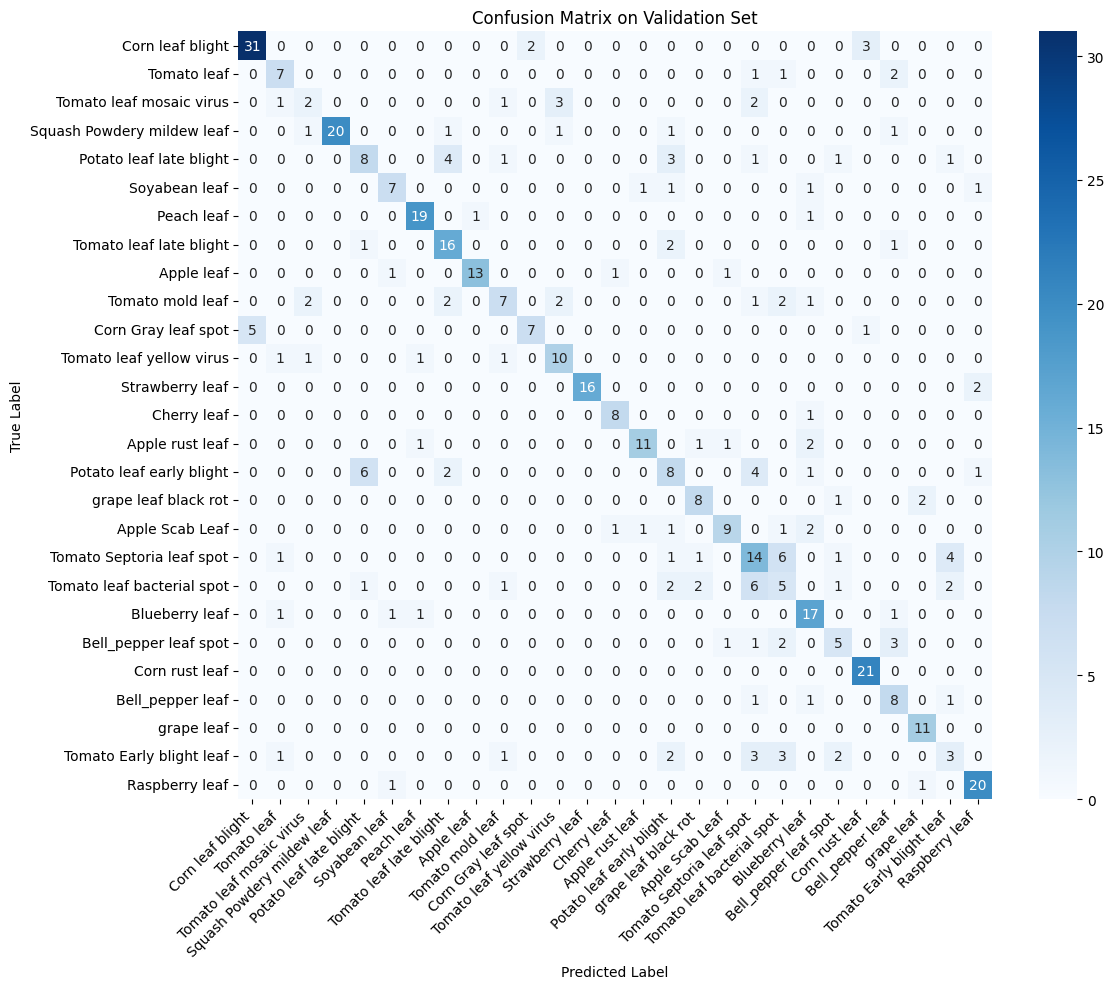

In [27]:
# Vẽ ma trận nhầm lẫn
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.title('Confusion Matrix on Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [28]:
# In báo cáo classification
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes, zero_division=0))



Classification Report:

                            precision    recall  f1-score   support

          Corn leaf blight       0.86      0.86      0.86        36
               Tomato leaf       0.58      0.64      0.61        11
  Tomato leaf mosaic virus       0.33      0.22      0.27         9
Squash Powdery mildew leaf       1.00      0.80      0.89        25
   Potato leaf late blight       0.50      0.42      0.46        19
             Soyabean leaf       0.70      0.64      0.67        11
                Peach leaf       0.86      0.90      0.88        21
   Tomato leaf late blight       0.64      0.80      0.71        20
                Apple leaf       0.93      0.81      0.87        16
          Tomato mold leaf       0.58      0.41      0.48        17
       Corn Gray leaf spot       0.78      0.54      0.64        13
  Tomato leaf yellow virus       0.62      0.71      0.67        14
           Strawberry leaf       1.00      0.89      0.94        18
               Cherry 


--- Biểu đồ quá trình Training ---


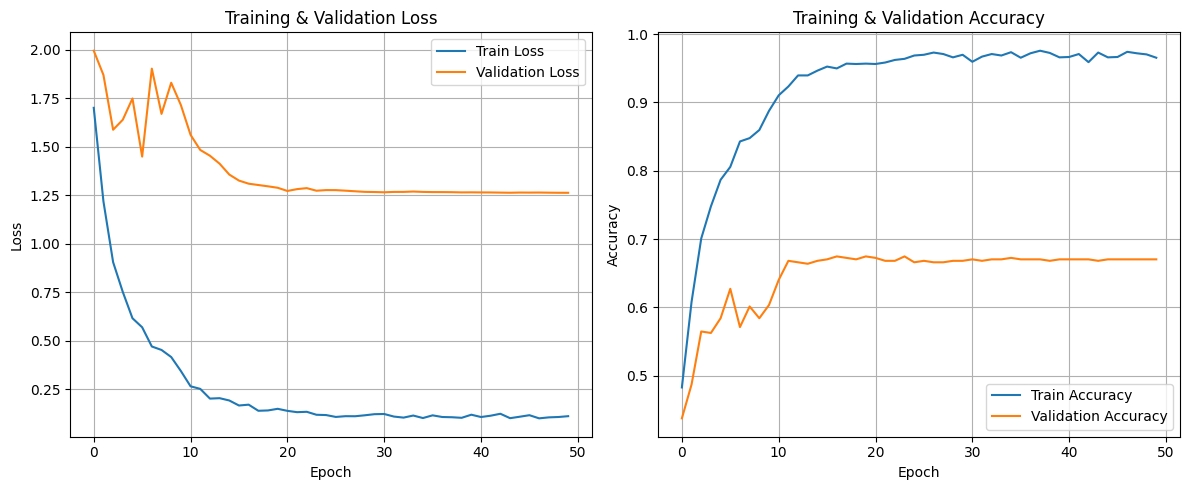

In [29]:
# Vẽ biểu đồ training history
print("\n--- Biểu đồ quá trình Training ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
torch.save(model.state_dict(), "efficientnetb0_plantdoc.pth")

In [31]:
model.load_state_dict(torch.load("efficientnetb0_plantdoc.pth"))
model.eval()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [32]:
def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_pixels, total_pixels = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device).float()
            labels = labels.to(device).long()

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_pixels += (preds == labels).sum().item()
            total_pixels += torch.numel(labels)

    avg_loss = running_loss / len(data_loader)
    accuracy = correct_pixels / total_pixels
    return avg_loss, accuracy

In [ ]:
model.load_state_dict(torch.load("efficientnetb0_plantdoc.pth"))
model.eval()
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history['train_loss'])+1)

plt.figure(figsize=(12,5))

# Vẽ Loss
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Vẽ Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train Acc')
plt.plot(epochs, history['val_acc'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()